In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
from scipy.io import loadmat
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import dotmap
from scipy.signal import find_peaks


In [ ]:

def data_download(kaggle_username,kaggle_key , dest_path="./data/pandaset",download=True):
    """
    Download PandaSet dataset from Kaggle

    Args:
        kaggle_username (str): Your Kaggle username.
        kaggle_key (str): Your Kaggle API key.
        dest_path (str): Destination path for dataset.
    """
    os.environ['KAGGLE_USERNAME'] = kaggle_username
    os.environ['KAGGLE_KEY'] = kaggle_key
    

    if download == True:
        from kaggle.api.kaggle_api_extended import KaggleApi
        # Set up Kaggle API
        os.makedirs(dest_path, exist_ok=True)
        api = KaggleApi()
        api.authenticate()

        # Download dataset to dest_path
        dataset_slug = "mkachuee/BloodPressureDataset"
        print("Downloading PandaSet...")
        api.dataset_download_files(
            dataset_slug,
            path=dest_path,
            unzip=True,
            quiet=False
        )
        print("Download complete — check:", dest_path)

    else:
        print("Already downloaded, no need to download again")

In [ ]:
# Use environment variable for security
load_dotenv()

kaggle_username = debug = os.environ.get('USER_NAME')
kaggle_key = os.environ.get('API_KEY')

# Set download=True to download
data_download(kaggle_username,kaggle_key , dest_path="./data",download=True)

Dataset URL: https://www.kaggle.com/datasets/mkachuee/BloodPressureDataset


100%|██████████| 4.60G/4.60G [05:49<00:00, 14.1MB/s]



Download complete — check: ./data


In [ ]:
All_PPG = []
All_ABP = []

for i in range(1, 13):  # part_1.mat to part_12.mat
    path = f"data/part_{i}.mat"
    mat = loadmat(path)
    num_seg=mat['p'].shape[1]
    PPG = []
    ABP = []
    for j in range(num_seg):
        sample = mat['p'][0,j]
        PPG.append(sample[0])
        ABP.append(sample[1])
    All_PPG.append(PPG)
    All_ABP.append(ABP)

print(len(All_PPG))  # should be 12


12


In [ ]:
fs = 125
b, a = butter(4, [0.5, 12], btype="bandpass", fs=fs)

ma_seconds = 0.05
ma_win = max(1, int(ma_seconds * fs))

ppg = All_PPG[0][0]
y = filtfilt(b, a, ppg)
y = uniform_filter1d(y, size=ma_win, mode="nearest")


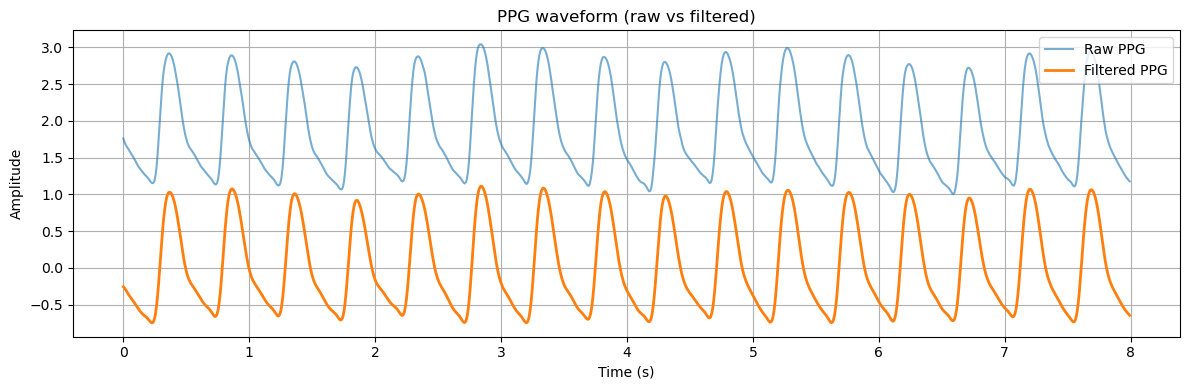

In [ ]:
raw_ppg = All_PPG[0][0][:1000]
filt_ppg = y[:1000]

t = np.arange(len(raw_ppg)) / fs

plt.figure(figsize=(12, 4))

plt.plot(t, raw_ppg, label="Raw PPG", alpha=0.6)
plt.plot(t, filt_ppg, label="Filtered PPG", linewidth=2)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("PPG waveform (raw vs filtered)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
def detect_ppg_peaks_and_onsets(ppg, fs):
    # 1) Systolic peaks
    sb_peaks, _ = find_peaks(
        ppg,
        distance=int(0.4 * fs),
    )

    # 2) Onsets: minimum before each systolic peak
    onsets = []

    for i in range(1,len(sb_peaks)):
        seg = ppg[sb_peaks[i-1]:sb_peaks[i]]
        if len(seg) < 5:
            onsets.append(None)
            continue
        onset = sb_peaks[i-1] + np.argmin(seg)
        onsets.append(onset)

    return sb_peaks, np.array(onsets)



In [129]:
def extract_ppg_beat_features(ppg, onsets, fs):
    feats = {
        "ibi": [],        # inter-beat interval
        "amp": [],        # pulse amplitude
        "ST": [],         # foot → peak
        "DT": [],         # peak → foot
        "width50": [],   # width at 50% amplitude
        "width66": [],   # width at 66% amplitude
    }

    for i in range(1, len(onsets)):
        o0, o1 = onsets[i-1], onsets[i]
        beat = ppg[o0:o1]
        # Skip segments that are too short to be a real beat
        if len(beat) < (fs * 0.3): # Example: skip if shorter than 0.3 seconds
            continue

        # IBI
        feats["ibi"].append((o1 - o0) / fs)

        # amplitude
        amp = np.max(beat) - beat[0]
        feats["amp"].append(amp)

        # ST
        peak_idx = np.argmax(beat)
        feats["ST"].append(peak_idx / fs)

        #DT
        feats["DT"].append((len(beat)-peak_idx) / fs)

        # width at 50% amplitude
        half = np.min(beat) + 0.5 * amp
        above = np.where(beat >= half)[0]
        if len(above) > 1:
            feats["width50"].append((above[-1] - above[0]) / fs)
        
        # width at 66% amplitude
        half = np.min(beat) + 0.66 * amp
        above = np.where(beat >= half)[0]
        if len(above) > 1:
            feats["width66"].append((above[-1] - above[0]) / fs)


    return feats


In [163]:
def summarize_segment_features(feats):
    out = {}
    for k, v in feats.items():
        v = np.asarray(v)
        if len(v):
            out[k + "_mean"] = float(np.mean(v))
    return out



In [164]:
def extract_bp(abp, fs=125):
    abp = np.asarray(abp)

    # systolic peaks
    sys_peaks, _ = find_peaks(abp, distance=int(0.35 * fs))
    sbp = abp[sys_peaks]

    # diastolic troughs
    dia_peaks, _ = find_peaks(-abp, distance=int(0.35 * fs))
    dbp = abp[dia_peaks]

    # safety check
    if len(sbp) == 0 or len(dbp) == 0:
        return np.nan, np.nan

    return sbp.mean(), dbp.mean()

In [165]:
All_X = []
All_y_sbp = []
All_y_dbp = []
for ppgs,abps in zip(All_PPG,All_ABP):
    X, y_sbp, y_dbp = [], [], []

    for ppg, abp in zip(ppgs, abps):
        ppg = filtfilt(b, a, ppg)
        ppg = uniform_filter1d(ppg, size=ma_win, mode="nearest")
        sb_peaks, onsets = detect_ppg_peaks_and_onsets(ppg, fs=125)
        if len(sb_peaks) < 3 or len(onsets) < 3:
            continue

        beat_feats = extract_ppg_beat_features(ppg, onsets, fs=125)
        seg_feats = summarize_segment_features(beat_feats)

        sbp, dbp = extract_bp(abp, fs=125)

        X.append(seg_feats)
        y_sbp.append(sbp)
        y_dbp.append(dbp)

    All_X.append(X)
    All_y_sbp.append(y_sbp)
    All_y_dbp.append(y_dbp)


In [166]:
print(len(All_X))
print(len(All_X[0]))
print(len(All_X[0][0]))
print(len(All_y_sbp))
print(len(All_y_sbp[0]))
print(len(All_y_dbp))
print(len(All_y_dbp[0]))

12
1000
6
12
1000
12
1000


In [167]:
X_list = [item for sublist in All_X for item in sublist]

X_df = pd.DataFrame(X_list)

print(X_df.head())
print(X_df.shape)
X_df.describe()


   ibi_mean  amp_mean   ST_mean   DT_mean  width50_mean  width66_mean
0  0.491616  1.743088  0.134924  0.356692      0.178661      0.140538
1  0.507958  1.728979  0.135121  0.372837      0.182368      0.142577
2  0.526389  1.715399  0.146469  0.379921      0.187327      0.146903
3  0.510800  1.740181  0.136666  0.374134      0.176842      0.138767
4  0.554538  1.752274  0.141519  0.413019      0.181253      0.142695
(12000, 6)


,ibi_mean,amp_mean,ST_mean,DT_mean,width50_mean,width66_mean
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.704847,1.419693,0.216147,0.488701,0.251277,0.191692
std,0.120660,0.521236,0.068562,0.112917,0.065958,0.052755
min,0.426127,0.237114,0.107168,0.155010,0.120789,0.088616
25%,0.616795,1.312846,0.166112,0.421035,0.201759,0.154182
50%,0.685672,1.653478,0.199305,0.490474,0.242715,0.184990
75%,0.789379,1.779229,0.244236,0.563764,0.288317,0.216999
max,1.276800,2.762741,0.719573,0.988800,0.722857,0.689714
